**Import Important Packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
import pickle
import os
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Implement Model Class**

In [2]:
class AutoComplete:


  def __init__(self, ngram, k_smoothing=0):
    self._model_trained = False
    self.ngram = ngram
    self._model_dict = dict()
    self._k_smoothing = k_smoothing
    



  @property
  def ngram(self):
    return self._ngram


  @ngram.setter
  def ngram(self, ngram):
    if type(ngram) != int:
      raise ValueError('Number of Ngram must be of type int.')
    if ngram <= 0:
      raise ValueError('Number of Ngram must be positive.')
    if self._model_trained:
      print('Warning you must train the model again in the altered ngram')
    self._ngram = ngram
    


  def fit(self, train_data, min_word_freq=5):
    preprocessed_data, self._vocabulary_dict = self.NLP_data_preprocessing(train_data, self.ngram, min_word_freq)
    for row in preprocessed_data:
      for key in row:
        if self._model_dict.get(key[:-1]) == None:
          self._model_dict[key[:-1]] = dict()
        self._model_dict[key[:-1]][key[-1]] = self._model_dict.get(key[:-1]).get(key[-1], 0) + 1

    if self._k_smoothing != 0:
      for key in self._model_dict.keys():
        self._model_dict[key] = (self._model_dict.get(key, 0) + self._k_smoothing) / (self._k_smoothing*len(self._vocabulary_dict))

    self.model_trained = True


  
  def pred_current_word(self, sentence, n_words=5):
      n_similar_words = (n_words // 2) + 1
      n_pred_words = n_words - n_similar_words
      pred_sentence, last_word = AutoComplete.extract_last_word(sentence)
      pred_words, found = self.pred_next_word(pred_sentence, n_pred_words)
      if not found:
        return AutoComplete.n_most_similar_words(last_word, list(self._vocabulary_dict), n_words)
      similar_words = AutoComplete.n_most_similar_words(last_word, list(self._vocabulary_dict), n_similar_words)


      return similar_words + pred_words



  def pred_next_word(self, sentence, n_words=5):
    if self.model_trained:
      found_key = False
      preprocessed_sentence = self.preprocessing_for_pred(sentence)[-1]
      if self._model_dict.get(preprocessed_sentence) != None:
        pred = AutoComplete.sort_dict(self._model_dict[preprocessed_sentence])
        found_key = True
      else:
        pred = self._vocabulary_dict
      return list(pred)[:n_words], found_key
                              
    else:
      raise RuntimeError('You must train model before prediction')



  def preprocessing_for_pred(self, row):
    row = row.lower()
    row = '<s> '*(self.ngram) + row
    row = row.strip()
    row = row.split(' ')
    row = AutoComplete.replace_unk_words(self._vocabulary_dict, row)
    return list(ngrams(row, self.ngram))



  def save(self, path, model_name):
    with open(os.path.join(path, model_name+'.pkl'), 'wb') as fp:
      pickle.dump(self, fp)
    print('model saved successfully to file.')



  @staticmethod
  def load(path):
    with open(path, 'rb') as fp:
      model = pickle.load(fp)
    print('model loaded successfully.')
    return model



  @staticmethod
  def NLP_data_preprocessing(train_data, ngram, min_word_freq=5):
    preprocessed_data = []
    for row in train_data:
      row = row.lower()
      row = '<s> '*(ngram) + row + ' </s>'
      row = row.split(' ')
      vocabulary_dict = AutoComplete.get_vocabulary_dict(train_data)
      vocabulary_dict_with_unk = AutoComplete.get_vocabulary_dict_with_unk(vocabulary_dict, min_word_freq)
      row = AutoComplete.replace_unk_words(vocabulary_dict_with_unk, row)
      preprocessed_data.append(list(ngrams(row, ngram+1)))
            
    return preprocessed_data, vocabulary_dict_with_unk


  @staticmethod
  def extract_last_word(sentence):
    sentence = sentence.strip()
    sentence = sentence.split(' ')
    last_word = sentence[-1]
    sentence.remove(last_word)
    sentence_without_last_word = ""
    for word in sentence:
      sentence_without_last_word += word + ' '
    sentence_without_last_word = sentence_without_last_word.strip()
    return sentence_without_last_word, last_word

  @staticmethod
  def get_vocabulary_dict(train_data):
    vocabulary_dict = dict()
    for row in train_data:
      row = row.lower()
      row = row.split(' ')
      for word in row:
        vocabulary_dict[word] = vocabulary_dict.get(word, 0) + 1

    sorted_vocabulary_dict = AutoComplete.sort_dict(vocabulary_dict)
    return sorted_vocabulary_dict

  @staticmethod
  def sort_dict(dict_):
    keys = list(dict_.keys())
    values = list(dict_.values())
    sorted_value_index = np.flip(np.argsort(values))
    sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
    return sorted_dict

  @staticmethod
  def get_vocabulary_dict_with_unk(vocabulary_dict, freq=5):
    vocabulary = list(vocabulary_dict.keys())
    for word in vocabulary:
      if vocabulary_dict.get(word) < freq and word != '<s>' and word != '</s>':
        vocabulary_dict['<unk>'] = vocabulary_dict.get('<unk>', 0) + vocabulary_dict.pop(word)

    return vocabulary_dict



  @staticmethod
  def replace_unk_words(vocabulary_dict, row):
    for index in range(len(row)):
      if row[index] not in vocabulary_dict.keys() and row[index] != '<s>' and row[index] != '</s>':
        row[index] = '<unk>'

    return row



  @staticmethod
  def n_most_similar_words(source, vocabulary_list, n=2):
    distance = np.array([])
    for target in vocabulary_list:
      distance =np.append(distance, AutoComplete.minimum_edit_distance(source, target))
    n_similar_indeces = distance.argsort()[:n]
    n_similar_vocabulary_list = []
    for index in n_similar_indeces:
      n_similar_vocabulary_list.append(vocabulary_list[index])

    return n_similar_vocabulary_list
     


  @staticmethod
  def minimum_edit_distance(source, target, case_sensitive=False):
    if not case_sensitive:
      source = source.lower()
      target = target.lower()
    insert_cost = 1
    delete_cost = 1
    source = '#' + source
    target = '#' + target
    distance_matrix = np.zeros((len(source), len(target)), int)
    for row in range(1,len(source)):
      distance_matrix[row][0] = distance_matrix[row-1][0] + delete_cost
    for col in range(1,len(target)):
      distance_matrix[0][col] = distance_matrix[0][col-1] + insert_cost
    for row in range(1,len(source)):
      for col in range(1,len(target)):
        replace_cost = 0 if source[row] == target[col] else 2
        distance_matrix[row][col] = min(distance_matrix[row][col-1] + delete_cost,
                                        distance_matrix[row-1][col] + insert_cost,
                                        distance_matrix[row-1][col-1] + replace_cost)
        
    return distance_matrix[len(source)-1][len(target)-1]

**Load Data**

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/Datasets/NLP Auto Complete/train.csv')
train_data.head()

,Unnamed: 0,query,intent,category
0,4158,Play the Instrumental Study on Vimeo .,PlayMusic,2
1,6232,Is there any hail in Monterey Bay National Mar...,GetWeather,3
2,4002,Play some jpop on Google Music .,PlayMusic,2
3,4110,"Play the playlist, A Mis Ninos de 30 .",PlayMusic,2
4,6963,Will there be hail around Khao Phanom Bencha N...,GetWeather,3


**Show Some Data statistics**

In [4]:
intent_values = train_data['intent'].unique()
print(intent_values)

['PlayMusic' 'GetWeather' 'AddToPlaylist' 'RateBook' 'SearchCreativeWork'
 'SearchScreeningEvent' 'BookRestaurant']


In [5]:
intent_counts = [np.sum(train_data['intent'] == class_)/len(train_data) for class_ in intent_values]
print(intent_counts)

[0.14509576320371445, 0.14509576320371445, 0.14088798607080674, 0.14190365641323274, 0.141758560650029, 0.1421213000580383, 0.1431369704004643]


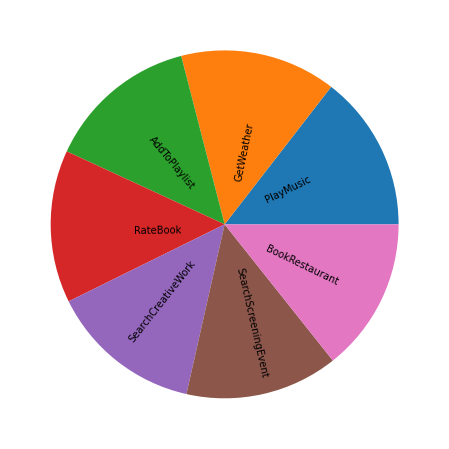

In [6]:
plt.figure(figsize=(8, 8))
#plt.hist(intent_counts, bins=intent_values)
plt.pie(intent_counts, labels=intent_values, labeldistance=0.25 ,rotatelabels=True)
plt.show()

**Define And Train The Model**

In [19]:
model = AutoComplete(2)
model.fit(train_data['query'], 5)

In [21]:
model._model_dict

{('<s>', '<s>'): {'play': 1685,
  'is': 421,
  'will': 413,
  'add': 1428,
  'rate': 869,
  'what': 1145,
  'i': 1285,
  'show': 496,
  'the': 97,
  "i'd": 295,
  'find': 1174,
  "what's": 280,
  'book': 1002,
  'please': 298,
  'can': 381,
  'give': 465,
  'table': 12,
  'how': 87,
  'out': 8,
  'weather': 62,
  'where': 244,
  'need': 40,
  'when': 107,
  'use': 44,
  'list': 25,
  'go': 15,
  'make': 46,
  'search': 55,
  'therese,': 1,
  'reserve': 25,
  'tell': 128,
  'for': 42,
  'turn': 4,
  'put': 180,
  'party': 4,
  'get': 26,
  'season': 1,
  'she': 11,
  'include': 17,
  "i'm": 90,
  'open': 42,
  'start': 5,
  'restaurant': 14,
  'bar': 1,
  'read': 6,
  'ethiopia': 1,
  'rat': 2,
  'look': 69,
  'this': 56,
  'want': 16,
  'stars': 1,
  'which': 39,
  'looking': 10,
  'forecast': 20,
  'during': 1,
  'diana': 1,
  'movie': 13,
  'download': 1,
  'forecase': 1,
  'listen': 10,
  'lets': 15,
  'programming': 1,
  'help': 11,
  'move': 3,
  'in': 35,
  "let's": 3,
  'there':

In [22]:
print(model.pred_current_word('play the Instru'))

['intrus', 'stu', 'finest', 'top', 'album']


In [23]:
sant = "mora"
while(True):
  pred, found = model.pred_next_word(sant)
  sant += ' ' + pred[0]
  sant = sant.strip()
  print(sant)
  if '</s>' in sant.split(' '):
    break

mora the
mora the the
mora the the tv
mora the the tv series
mora the the tv series </s>


In [25]:
model._model_dict.get(('tv', 'series'))

{'the': 10,
 '</s>': 18,
 'rat': 1,
 ',': 3,
 'krieg': 1,
 'of': 2,
 'effortless': 1,
 'lego': 1,
 'titled': 3,
 'to': 1,
 'called': 15,
 'crossing': 1,
 'schedule': 1,
 'treeful': 1,
 'from': 1,
 'sailor': 1,
 'bet': 1,
 'shopping': 1,
 'truly': 1,
 'i': 1,
 '.': 2,
 'in': 1,
 'for': 1,
 '?': 3,
 'strays': 1,
 'mothstorm': 1,
 '7even': 1,
 'shaun': 1,
 'heart': 1,
 'breed': 1,
 'box': 1,
 'polite': 1,
 'operace': 1,
 'liar': 1,
 'puppet': 1,
 'a': 2,
 'back': 1,
 'all': 1,
 'love': 1,
 'prescription': 1}

In [26]:
model._vocabulary_dict

{'the': 7416,
 'a': 4386,
 'in': 3438,
 'to': 3398,
 'for': 3045,
 'of': 2564,
 'at': 2104,
 'play': 1913,
 'i': 1849,
 '.': 1759,
 'is': 1630,
 'book': 1610,
 'add': 1578,
 'find': 1403,
 'my': 1400,
 'what': 1208,
 'me': 1201,
 'on': 1188,
 'this': 1187,
 '6': 1128,
 'movie': 1110,
 'from': 1072,
 '?': 1055,
 'rate': 1005,
 'playlist': 1002,
 'and': 944,
 'weather': 880,
 'by': 841,
 'be': 825,
 'show': 801,
 'give': 747,
 'restaurant': 741,
 'out': 736,
 'will': 728,
 'it': 650,
 'want': 648,
 'can': 603,
 'current': 595,
 'music': 582,
 'stars': 576,
 'forecast': 566,
 'points': 561,
 'like': 539,
 'table': 528,
 'playing': 513,
 '': 498,
 'album': 494,
 'movies': 473,
 'song': 440,
 'that': 390,
 'now': 390,
 'need': 388,
 ',': 384,
 'you': 363,
 'one': 358,
 'called': 358,
 '1': 347,
 'are': 347,
 'schedule': 344,
 'please': 331,
 'with': 329,
 'some': 327,
 'theatres': 318,
 "i'd": 307,
 'playlist.': 306,
 'track': 290,
 'house': 285,
 "what's": 282,
 'four': 280,
 'reservation'

In [27]:
model._vocabulary_dict.get('instrumental')

15

In [28]:
AutoComplete.minimum_edit_distance('pla', '')

3

In [33]:
model.pred_next_word('play the')

(['top', 'album', 'song', 'most', 'greatest'], True)

In [30]:
model.save('/content/sample_data', 'model')

model saved successfully to file.


In [31]:
model2 = AutoComplete.load('/content/sample_data/model.pkl')

model loaded successfully.


In [32]:
model2._model_dict

{('<s>', '<s>'): {'play': 1685,
  'is': 421,
  'will': 413,
  'add': 1428,
  'rate': 869,
  'what': 1145,
  'i': 1285,
  'show': 496,
  'the': 97,
  "i'd": 295,
  'find': 1174,
  "what's": 280,
  'book': 1002,
  'please': 298,
  'can': 381,
  'give': 465,
  'table': 12,
  'how': 87,
  'out': 8,
  'weather': 62,
  'where': 244,
  'need': 40,
  'when': 107,
  'use': 44,
  'list': 25,
  'go': 15,
  'make': 46,
  'search': 55,
  'therese,': 1,
  'reserve': 25,
  'tell': 128,
  'for': 42,
  'turn': 4,
  'put': 180,
  'party': 4,
  'get': 26,
  'season': 1,
  'she': 11,
  'include': 17,
  "i'm": 90,
  'open': 42,
  'start': 5,
  'restaurant': 14,
  'bar': 1,
  'read': 6,
  'ethiopia': 1,
  'rat': 2,
  'look': 69,
  'this': 56,
  'want': 16,
  'stars': 1,
  'which': 39,
  'looking': 10,
  'forecast': 20,
  'during': 1,
  'diana': 1,
  'movie': 13,
  'download': 1,
  'forecase': 1,
  'listen': 10,
  'lets': 15,
  'programming': 1,
  'help': 11,
  'move': 3,
  'in': 35,
  "let's": 3,
  'there':

In [64]:
sentence = ''
while(True):
  words = input('enter your words: ')
  sentence += ' ' + words
  sentence = sentence.strip()
  print('if you want to complete last word press 1.')
  print('if you want to predict next word press 2.') 
  choice = int(input('enter your choice: '))

  if choice == 1:
    pred = model.pred_current_word(sentence)
  elif choice == 2:
    pred, found = model.pred_next_word(sentence)
  else:
    print('invalid choice')
    continue
  
  option = input('are you want to chose from predicted words y/n :')
  if(option.lower() == 'y'):
    print(pred)
    index = int(input('enter the number of word you want to choose: '))
    sentence += ' ' + pred[index-1]

  print(sentence)

  if '</s>' in sentence.split(' '):
    print('sentence is complete.')
    print('Thanks for using our program ^_^.')
    break

enter your words: play
if you want to complete last word press 1.
if you want to predict next word press 2.
enter your choice: 2
are you want to chose from predicted words y/n :y
['the', 'some', 'a', 'music', 'me']
enter the number of word you want to choose: 1
play the
enter your words: 
if you want to complete last word press 1.
if you want to predict next word press 2.
enter your choice: 2
are you want to chose from predicted words y/n :y
['top', 'album', 'song', 'most', 'greatest']
enter the number of word you want to choose: 2
play the album
enter your words: 
if you want to complete last word press 1.
if you want to predict next word press 2.
enter your choice: 2
are you want to chose from predicted words y/n :y
['to', 'the', ',', 'by', 'onto']
enter the number of word you want to choose: 1
play the album to
enter your words: me
if you want to complete last word press 1.
if you want to predict next word press 2.
enter your choice: 2
are you want to chose from predicted words y/n 